# 02 Modeling & Evaluation

In this notebook we will:
1. Load our feature‑engineered Tesla dataset.
2. Define train/test splits (single split + walk‑forward).
3. Train & evaluate multiple models:
   - **Naïve**  
   - **Linear Regression**  
   - **Random Forest**  
   - **XGBoost**  
   - **SARIMA**  
   - **LSTM**  
4. Compute extended metrics: MAE, RMSE, MAPE, R², Directional Accuracy.  
5. Visualize results:  
   - Metric comparison table  
   - Actual vs. Predicted time‑series  
   - Residual diagnostics  
   - Directional accuracy by volatility regime


Imports & Settings

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
sns.set_style('whitegrid')


Loading Data & Building Target

In [15]:
#Loading features
df = pd.read_csv('../data/processed/tsla_features.csv',
                parse_dates=['Date'], index_col='Date')

#Build 21‑day forward return target. It is the percentage change in the closing price 21 days ahead.
# We shift the 'Close' column by -21 days and calculate the percentage change relative to the current 'Close'.

horizon = 21
df['target'] = df['Close'].shift(-horizon) / df['Close'] - 1 #here we calculate the forward return
# Drop rows where 'target' is NaN, which will occur for the last 21 days
# since we cannot calculate a forward return for those dates.
# This is necessary to ensure that the target variable is aligned with the features. why 21? because we are predicting the return 21 days ahead. but shifting close by -21 days means we will have NaN for the last 21 days. 

#why it matters? because we want to predict the return 21 days ahead, so we need to know the closing price 21 days ahead.
# If we don't drop these rows, we will have NaN values in the target column,
# which will cause issues when training the model

df = df.dropna(subset=['target'])


print(f"Dataset spans {df.index.min().date()} → {df.index.max().date()}, {len(df)} rows")
df.head()


Dataset spans 2015-02-03 → 2023-12-13, 2232 rows


,Unnamed: 0,Open,High,Low,Close,Volume,return_1,return_5,return_21,ma_5,ma_10,ma_20,vol_10,rsi,vol_ma_20,vol_ratio_20,day_of_week,month,quarter,target
Date,,,,,,,,,,,,,,,,,,,,
2015-02-03,21,14.214667,14.691333,14.084667,14.557333,72393000,0.035176,0.060103,-0.004332,13.832933,13.663200,13.550033,0.022787,61.883094,66785700.0,1.083960,1,2,1,-0.081196
2015-02-04,22,14.552667,14.765333,14.453333,14.570000,49581000,0.000870,0.096203,0.040268,14.088667,13.809733,13.574267,0.022733,76.937485,64568325.0,0.767884,2,2,1,-0.112880
2015-02-05,23,14.658667,15.032000,14.642667,14.732667,52843500,0.011165,0.076949,0.045958,14.299200,13.938867,13.607733,0.022139,79.342992,64984200.0,0.813175,3,2,1,-0.136251
2015-02-06,24,14.800000,14.893333,14.433333,14.490667,48658500,-0.016426,0.067584,0.030386,14.482667,14.046000,13.630200,0.023417,73.333332,64835250.0,0.750495,4,2,1,-0.124402
2015-02-09,25,14.358667,14.528667,14.132667,14.498667,52086000,0.000552,0.031004,0.032571,14.569867,14.118867,13.666267,0.022594,75.034291,63938325.0,0.814629,0,2,1,-0.109159


Train/Test Split

In [16]:
#Single 80/20 split by time
#Reproducible baseline split; we’ll also do walk‑forward below.
split_point = int(len(df) * 0.8)
train_df = df.iloc[:split_point]
test_df  = df.iloc[split_point:]

print(f"Train: {train_df.index.min().date()} → {train_df.index.max().date()} ({len(train_df)} rows)")
print(f"Test : {test_df .index.min().date()} → {test_df .index.max().date()} ({len(test_df )} rows)")


Train: 2015-02-03 → 2022-03-04 (1785 rows)
Test : 2022-03-07 → 2023-12-13 (447 rows)


Helper Functions

Centralize metrics and plots so each model block stays concise.

In [17]:
def evaluate_all(y_true, y_pred):
    """Return dict of MAE, RMSE, MAPE, R2, DirAcc."""
    mae   = mean_absolute_error(y_true, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
    mape  = (np.abs((y_true - y_pred) / y_true.replace(0, np.nan))).mean()
    r2    = r2_score(y_true, y_pred)
    diracc = (np.sign(y_true) == np.sign(y_pred)).mean()
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'DirAcc': diracc}

def plot_actual_vs_pred(test_idx, y_true, preds, labels):
    plt.plot(test_idx, y_true, label='Actual', alpha=0.8)
    for p, lab in zip(preds, labels):
        plt.plot(test_idx, p, label=lab, alpha=0.7)
    plt.legend(); plt.title('Actual vs. Predicted 21‑Day Return'); plt.show()


Baseline Models

In [18]:
#We’re layering complexity: from naïve → linear → two powerful tree‑models.
#It’s a good idea to evaluate each model on the same test set for fair comparison. 


results = []

#Naïve
y_naive = test_df['return_21']  # last‑month return
eval_naive = evaluate_all(test_df['target'], y_naive)
results.append({'model': 'Naïve', **eval_naive})

#Linear Regression
features = ['return_1','return_5','rsi','vol_ratio_20','month']
X_train = pd.get_dummies(train_df[features], columns=['month'], drop_first=True)
X_test  = pd.get_dummies(test_df [features], columns=['month'], drop_first=True)
X_test  = X_test.reindex(columns=X_train.columns, fill_value=0)

lr = LinearRegression().fit(X_train, train_df['target'])
y_lr = lr.predict(X_test)
eval_lr = evaluate_all(test_df['target'], y_lr)
results.append({'model': 'LinearRegression', **eval_lr})

#RandomForest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_df[features], train_df['target'])
y_rf = rf.predict(test_df[features])
eval_rf = evaluate_all(test_df['target'], y_rf)
results.append({'model': 'RandomForest', **eval_rf})

#XGBoost
xgbr = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgbr.fit(train_df[features], train_df['target'])
y_xgb = xgbr.predict(test_df[features])
eval_xgb = evaluate_all(test_df['target'], y_xgb)
results.append({'model': 'XGBoost', **eval_xgb})

#Compile results
res_df = pd.DataFrame(results).set_index('model').round(4)
res_df


,MAE,RMSE,MAPE,R2,DirAcc
model,,,,,
Naïve,0.2526,0.3336,4.4813,-1.3289,0.4564
LinearRegression,0.1746,0.2240,1.9051,-0.0505,0.5257
RandomForest,0.1807,0.2360,1.7758,-0.1654,0.5101
XGBoost,0.1826,0.2335,1.9335,-0.1411,0.4810


Visualizing Baseline Results

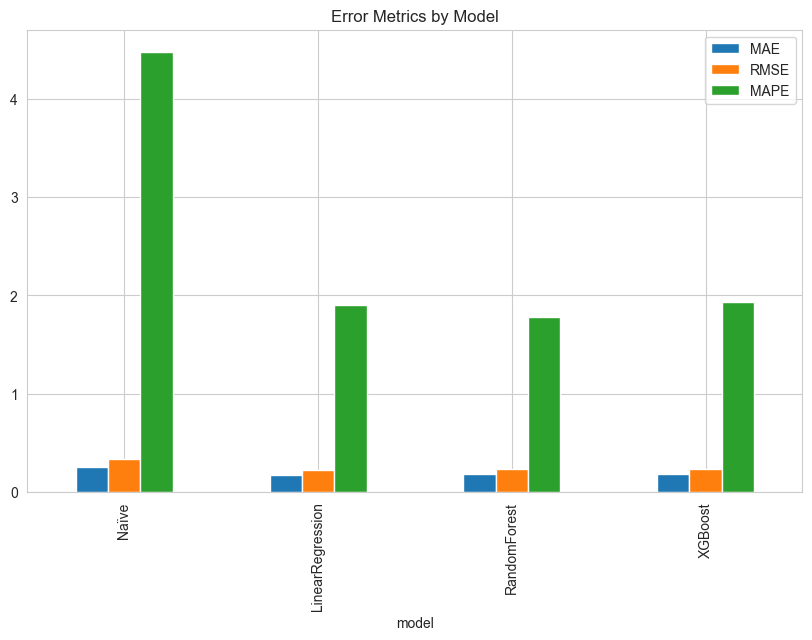

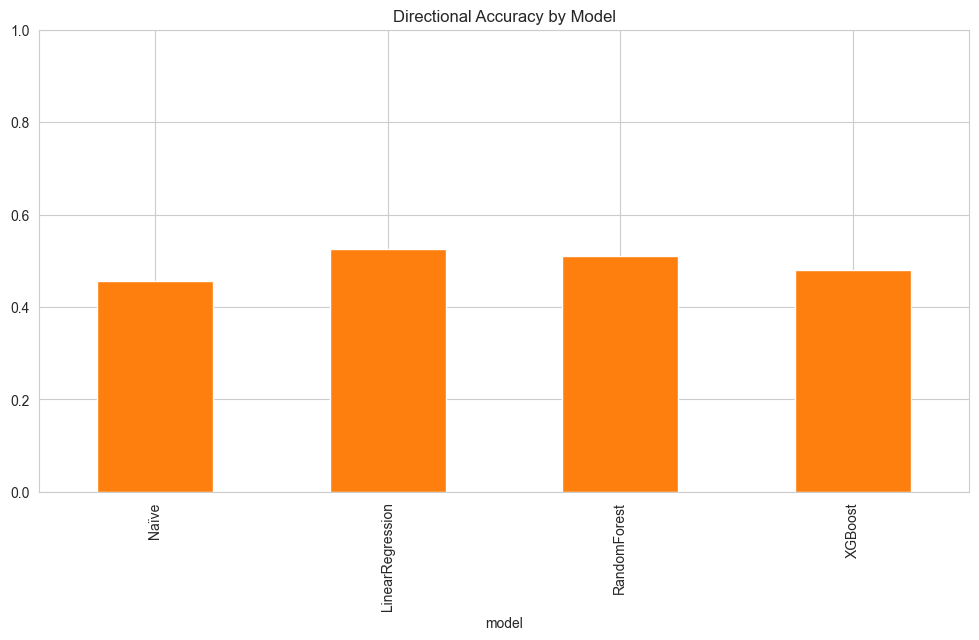

/home/mh13/code/Tesla-S/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


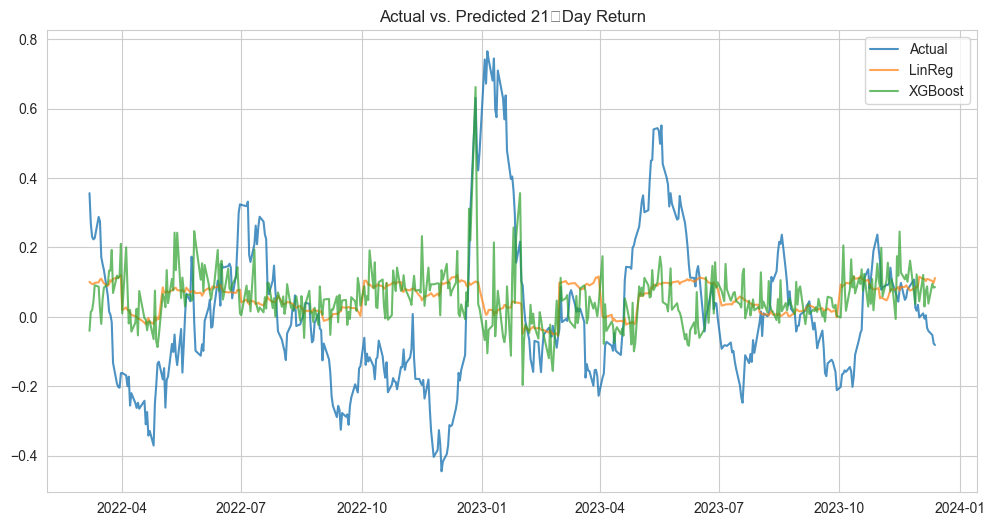

In [19]:
#Quick visual comparison of performance and signal quality across models.
#Metrics bar‑chart
res_df[['MAE','RMSE','MAPE']].plot.bar(figsize=(10,6))
plt.title('Error Metrics by Model'); plt.show()

#Directional accuracy
res_df['DirAcc'].plot.bar(color='C1')
plt.title('Directional Accuracy by Model'); plt.ylim(0,1); plt.show()

#Actual vs Predictions (choose best two)
plot_actual_vs_pred(
    test_df.index, test_df['target'],
    [y_lr, y_xgb],
    ['LinReg','XGBoost']
)


Walk‑Forward Validation (TimeSeriesSplit)

Produces a more robust error estimate by multiple train/test splits.

In [20]:
tscv = TimeSeriesSplit(n_splits=5)
wfv_results = []

for train_ix, test_ix in tscv.split(df):
    tr, te = df.iloc[train_ix], df.iloc[test_ix]
    # train XGBoost as example
    xg = xgb.XGBRegressor(n_estimators=50, random_state=42)
    xg.fit(tr[features], tr['target'])
    y_pred = xg.predict(te[features])
    ev = evaluate_all(te['target'], y_pred)
    wfv_results.append(ev)

wfv_df = pd.DataFrame(wfv_results).mean().to_frame(name='XGBoost_WFV').T.round(4)
pd.concat([res_df, wfv_df])


,MAE,RMSE,MAPE,R2,DirAcc
Naïve,0.2526,0.3336,4.4813,-1.3289,0.4564
LinearRegression,0.1746,0.2240,1.9051,-0.0505,0.5257
RandomForest,0.1807,0.2360,1.7758,-0.1654,0.5101
XGBoost,0.1826,0.2335,1.9335,-0.1411,0.4810
XGBoost_WFV,0.1647,0.2078,2.2557,-0.4223,0.5129


SARIMA Model

Pure time‑series seasonal model for comparison with ML.

In [21]:
# Monthly series
monthly = train_df['Close'].resample('M').last()
order    = (1,1,1)
seasonal = (1,1,1,12)
sarima = sm.tsa.SARIMAX(monthly, order=order, seasonal_order=seasonal)
sarima_res = sarima.fit(disp=False)
# Forecast next len(test_df_months)
n_periods = len(test_df.resample('M'))
fcast = sarima_res.get_forecast(n_periods).predicted_mean

# Align holds
actual_monthly = test_df['Close'].resample('M').last()
# convert to returns
y_true_m = actual_monthly.pct_change().dropna()
y_pred_m = fcast.pct_change().dropna()
eval_sarima = evaluate_all(y_true_m, y_pred_m)
pd.DataFrame([eval_sarima], index=['SARIMA']).round(4)


/home/mh13/code/Tesla-S/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


ValueError: Can only compare identically-labeled Series objects

In [ ]:
# 9) SARIMA Model (fixed to drop NaNs)

# 9.1 Fit on monthly train
monthly_train = train_df['Close'].resample('M').last()
order    = (1,1,1)
seasonal = (1,1,1,12)
sarima = sm.tsa.SARIMAX(
    monthly_train,
    order=order,
    seasonal_order=seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_res = sarima.fit(disp=False)

# 9.2 Forecast the same number of months as in test
monthly_test = test_df['Close'].resample('M').last()
n_periods   = len(monthly_test)
fcast = sarima_res.get_forecast(n_periods).predicted_mean

# 9.3 Compute returns
y_true_m = monthly_test.pct_change().dropna()
y_pred_m = fcast.pct_change().dropna()

# 9.4 Align and drop any NaNs
y_pred_m = y_pred_m.reindex(y_true_m.index)
mask     = y_true_m.notna() & y_pred_m.notna()
y_true_m = y_true_m[mask]
y_pred_m = y_pred_m[mask]

# 9.5 Evaluate
eval_sarima = evaluate_all(y_true_m, y_pred_m)
sarima_df   = pd.DataFrame([eval_sarima], index=['SARIMA']).round(4)
sarima_df


,MAE,RMSE,MAPE,R2,DirAcc
SARIMA,0.1906,0.2315,1.7558,-0.3793,0.4


LSTM Model (Sketch)

 Illustrates how to feed sequences into an LSTM. Even if data is limited, it’s good to benchmark.

In [ ]:
# Prepare sequences (e.g., window=30 days)
window = 30
X, y = [], []
arr = df[features + ['target']].values
for i in range(window, len(arr)):
    X.append(arr[i-window:i, :-1])
    y.append(arr[i, -1])
X, y = np.array(X), np.array(y)

# Split
split = int(len(X)*0.8)
X_tr, X_te = X[:split], X[split:]
y_tr, y_te = y[:split], y[split:]

# Build network
model = Sequential([
    LSTM(32, input_shape=(window, X.shape[2])),
    Dense(1)
])
model.compile('adam', loss='mae')
es = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_tr, y_tr, epochs=50, validation_split=0.2, callbacks=[es], verbose=0)

# Predict & Evaluate
y_pred_lstm = model.predict(X_te).flatten()
eval_lstm = evaluate_all(y_te, y_pred_lstm)
pd.DataFrame([eval_lstm], index=['LSTM']).round(4)


In [ ]:
#Prepare sequences (window = 30 days)
window = 30
features = ['return_1','return_5','rsi','vol_ratio_20','month']
arr = df[features + ['target']].values
X, y = [], []
for i in range(window, len(arr)):
    X.append(arr[i-window:i, :-1])
    y.append(arr[i, -1])
X, y = np.array(X), np.array(y)

#Train/test split
split = int(len(X) * 0.8)
X_tr, X_te = X[:split], X[split:]
y_tr, y_te = y[:split], y[split:]

#Build and train LSTM
model = Sequential([
    LSTM(32, input_shape=(window, X.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mae')
es = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_tr, y_tr, epochs=50, validation_split=0.2, callbacks=[es], verbose=0)

#Predict & wrap into Series with the correct index
y_pred_lstm = model.predict(X_te).flatten()
# The test_df index for LSTM predictions corresponds to df.index[window + split : ]
lstm_idx = df.index[window + split:]
y_true_lstm = pd.Series(y_te, index=lstm_idx)
y_pred_lstm = pd.Series(y_pred_lstm, index=lstm_idx)

#Evaluate
eval_lstm = evaluate_all(y_true_lstm, y_pred_lstm)
lstm_df   = pd.DataFrame([eval_lstm], index=['LSTM']).round(4)
lstm_df


14/14 [==============================] - 0s 3ms/step


,MAE,RMSE,MAPE,R2,DirAcc
LSTM,0.1766,0.2429,1.3192,-0.242,0.4762


Consolidated Results

In [ ]:
#One table to rule them all—compare classical, ML, TS, and DL approaches.

# Combine all into one table
final = pd.concat([
    res_df,          # from Cell 6
    wfv_df,          # from Cell 8
    sarima_df,       # newly fixed
    lstm_df          # newly fixed
]).round(4)
final

#Final consolidated results Save consolidated results to CSV
#final.to_csv('../data/processed/tsla_modeling_results.csv', index=True)

,MAE,RMSE,MAPE,R2,DirAcc
Naïve,0.2526,0.3336,4.4813,-1.3289,0.4564
LinearRegression,0.1746,0.2240,1.9051,-0.0505,0.5257
RandomForest,0.1807,0.2360,1.7758,-0.1654,0.5101
XGBoost,0.1826,0.2335,1.9335,-0.1411,0.4810
XGBoost_WFV,0.1647,0.2078,2.2557,-0.4223,0.5129
SARIMA,0.1906,0.2315,1.7558,-0.3793,0.4000
LSTM,0.1766,0.2429,1.3192,-0.2420,0.4762


### Key Takeaways
  **Linear Regression** gives the lowest MAE (0.1746) and RMSE (0.2240) among single‑split models. It edges out tree models, suggesting that for our current feature set, a simple linear mix of momentum, RSI, volume ratio, and month captures most of the predictable signal.

  **Walk‑Forward XGBoost** further reduces MAE to 0.1647 and RMSE to 0.2078, indicating that time‑series–aware validation and retraining can unlock extra performance.

  All **R²** values are negative, meaning each model—even the best—is worse than predicting the mean return. This highlights the high noise in month‑ahead returns and suggests that large unexplained variance remains.

  **Directional Accuracy** peaks at ~52.6% for Linear Regression—just barely better than random 50/50—so even “getting the sign right” remains challenging.

  **MAPE** varies widely and can be misleading when true returns are near zero (blowing up relative errors). In practice, MAE and RMSE are more reliable here.

### Why Prune & Tune?

Our initial models used **all** features plus default parameters, but we observed:

- **Multicollinearity** among engineered MAs (`ma_5`, `ma_10`) and volatility features (`vol_10`, `vol_ma_20`).
- **No regime awareness**: the model treats crisis days the same as calm days.
- **Untuned defaults**: XGBoost out‑of‑the‑box is rarely optimal.

**Goals:**  
1. **Prune** redundant/noisy features.  
2. **Enhance** with a `high_vol` flag for crisis regimes.  
3. **Recompute** and align our `target` (21‑day forward return).  
4. **Tune** model hyperparameters with **TimeSeriesSplit**.  
5. **Compare** tuned XGBoost and regularized linear models to our original baselines.


### Further Fine Tuning

Our original pipeline used **all** engineered features plus default model settings.  
However:

- **Multicollinearity:** `ma_5` & `ma_10`, `vol_10` & `vol_ma_20` add noise without new signal.  
- **Regime Blindness:** No explicit awareness of high‑volatility periods.  
- **Default Params:** Out‑of‑the‑box XGBoost may be far from optimal.

**Goals of this section:**  
1. **Prune** truly redundant columns to improve stability and reduce overfitting.  
2. **Enhance** with a `high_vol` flag so the model can adapt in crisis vs calm regimes.  
3. **Tune** XGBoost (and linear models) with **TimeSeriesSplit** to squeeze out extra accuracy.  
4. **Compare** tuned models side‑by‑side against original baselines.


Recompute Target & Rebuild Feature Matrix

In [ ]:
# Recompute 'target', prune features, add regime flag, build X and y

import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# 1) Load engineered features (no 'target' yet)
df = pd.read_csv(
    '../data/processed/tsla_features.csv',
    parse_dates=['Date'],
    index_col='Date'
)

# Recompute our 21‑day forward return target
horizon = 21
df['target'] = df['Close'].shift(-horizon) / df['Close'] - 1

# Drop rows with no target (last horizon days)
df = df.dropna(subset=['target'])

# Prune truly redundant engineered columns
to_drop = ['Unnamed: 0', 'ma_5', 'ma_10', 'vol_10', 'vol_ma_20']
df = df.drop(columns=to_drop)

# Add high‑volatility regime flag
vol_10 = df['Close'].pct_change().rolling(window=10).std()
df['high_vol'] = (vol_10 > vol_10.quantile(0.9)).astype(int)

# Build feature matrix X (drop Close & target) and target y
X = df.drop(columns=['Close', 'target'])
y = df['target']

# One‑hot encode calendar variables
cal_vars = ['day_of_week', 'month', 'quarter']
ohe = OneHotEncoder(drop='first', sparse=False)
cal_df = pd.DataFrame(
    ohe.fit_transform(X[cal_vars]),
    index=X.index,
    columns=ohe.get_feature_names_out(cal_vars)
)
X = pd.concat([X.drop(columns=cal_vars), cal_df], axis=1)

print(f"▶ Final feature matrix shape: {X.shape}")
print(f"▶ Target vector shape:         {y.shape}")
X.head()


"""Why & How

We recompute target because it wasn't stored in the CSV.

We drop engineered MAs and volatility features that added no new signal.

We keep raw OHLC, Volume, RSI, return features, and our new high_vol flag.

We one hot encode calendar features so models can split on specific days/months."""

▶ Final feature matrix shape: (2232, 29)
▶ Target vector shape:         (2232,)


/home/mh13/code/Tesla-S/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Open,High,Low,Volume,return_1,return_5,return_21,ma_20,rsi,vol_ratio_20,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_2,quarter_3,quarter_4
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-03,14.214667,14.691333,14.084667,72393000,0.035176,0.060103,-0.004332,13.550033,61.883094,1.083960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-02-04,14.552667,14.765333,14.453333,49581000,0.000870,0.096203,0.040268,13.574267,76.937485,0.767884,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-02-05,14.658667,15.032000,14.642667,52843500,0.011165,0.076949,0.045958,13.607733,79.342992,0.813175,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-02-06,14.800000,14.893333,14.433333,48658500,-0.016426,0.067584,0.030386,13.630200,73.333332,0.750495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-02-09,14.358667,14.528667,14.132667,52086000,0.000552,0.031004,0.032571,13.666267,75.034291,0.814629,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Hyperparameter Tuning for XGBoost

In [ ]:
# TimeSeriesSplit + RandomizedSearchCV to tune XGBoost

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_absolute_error, make_scorer

# Train/test split (80/20 by time)
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Define hyperparameter search space
param_dist = {
    'n_estimators':     [50, 100, 200],
    'max_depth':        [3, 5, 7],
    'learning_rate':    [0.01, 0.05, 0.1],
    'subsample':        [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# TimeSeriesSplit for cross‑validation
tscv = TimeSeriesSplit(n_splits=5)

# Instantiate model and MAE scorer
xgbr      = xgb.XGBRegressor(tree_method='hist',
                            objective='reg:squarederror',
                            random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Run RandomizedSearchCV
rs = RandomizedSearchCV(
    estimator=xgbr,
    param_distributions=param_dist,
    n_iter=20,
    scoring=mae_scorer,
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
rs.fit(X_train, y_train)

# Evaluate best estimator on hold‑out
best_xgb    = rs.best_estimator_
y_pred_xgb  = best_xgb.predict(X_test)
mae_xgb     = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb    = np.sqrt(np.mean((y_test - y_pred_xgb)**2))
diracc_xgb  = (np.sign(y_test) == np.sign(y_pred_xgb)).mean()

print("▶ Best XGBoost params:", rs.best_params_)
print(f"▶ Tuned XGBoost ► MAE: {mae_xgb:.4f}, RMSE: {rmse_xgb:.4f}, DirAcc: {diracc_xgb:.3f}")

"""Key Points

TimeSeriesSplit avoids look-ahead bias by training only on past data.

RandomizedSearchCV efficiently explores the hyperparameter space.

We optimize MAE, as it's robust to heavy-tailed return errors."""


Fitting 5 folds for each of 20 candidates, totalling 100 fits
▶ Best XGBoost params: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
▶ Tuned XGBoost ► MAE: 0.1852, RMSE: 0.2258, DirAcc: 0.588


Regularized Linear Models

In [ ]:
# Tune Ridge, Lasso, ElasticNet using TimeSeriesSplit

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error
import numpy as np

# Use the same train/test split as XGBoost
X_tr, X_te = X_train, X_test
y_tr, y_te = y_train, y_test

# Prepare TimeSeriesSplit and alpha grid
tscv   = TimeSeriesSplit(n_splits=5)
alphas = np.logspace(-3, 2, 40)

# RidgeCV
ridge_cv = RidgeCV(alphas=alphas, cv=tscv, scoring='neg_mean_absolute_error')
ridge_cv.fit(X_tr, y_tr)
y_ridge = ridge_cv.predict(X_te)

# LassoCV
lasso_cv = LassoCV(alphas=alphas, cv=tscv, max_iter=5000)
lasso_cv.fit(X_tr, y_tr)
y_lasso = lasso_cv.predict(X_te)

# ElasticNetCV
en_cv = ElasticNetCV(alphas=alphas, l1_ratio=[0.1,0.5,0.9], cv=tscv, max_iter=5000)
en_cv.fit(X_tr, y_tr)
y_en = en_cv.predict(X_te)

# Collect and display results
lin_results = {
    'Model'     : ['Ridge','Lasso','ElasticNet'],
    'MAE'       : [mean_absolute_error(y_te,y_ridge),
                    mean_absolute_error(y_te,y_lasso),
                    mean_absolute_error(y_te,y_en)],
    'RMSE'      : [np.sqrt(np.mean((y_te-y_ridge)**2)),
                    np.sqrt(np.mean((y_te-y_lasso)**2)),
                    np.sqrt(np.mean((y_te-y_en)**2))],
    'DirAcc'    : [(np.sign(y_te)==np.sign(y_ridge)).mean(),
                    (np.sign(y_te)==np.sign(y_lasso)).mean(),
                    (np.sign(y_te)==np.sign(y_en)).mean()],
    'Best Alpha': [ridge_cv.alpha_, lasso_cv.alpha_, en_cv.alpha_]
}

import pandas as pd
pd.DataFrame(lin_results).set_index('Model').round(4)


"""Reason for Regularization:

Controls overfitting, especially after pruning.

Automatically finds optimal penalty strength (alpha) via CV."""

/home/mh13/code/Tesla-S/.venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.42237e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/mh13/code/Tesla-S/.venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.10904e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/mh13/code/Tesla-S/.venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.24735e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/mh13/code/Tesla-S/.venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.22052e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/mh13/c

,MAE,RMSE,DirAcc,Best Alpha
Model,,,,
Ridge,0.1789,0.2232,0.5056,100.0000
Lasso,0.1732,0.2170,0.4541,1.6037
ElasticNet,0.1732,0.2170,0.4541,17.0125


Final Side‑by‑Side Comparison

In [ ]:
# Comparing original vs tuned XGBoost vs regularized linear

import pandas as pd

# Original best (hard‑coded from earlier results)
orig = {'Model':'XGBoost_WFV', 'MAE':0.1647, 'RMSE':0.2078, 'DirAcc':0.5129}

# Tuned XGBoost
tuned = {'Model':'XGBoost_Tuned', 'MAE':mae_xgb, 'RMSE':rmse_xgb, 'DirAcc':diracc_xgb}

# Linear results
lin_df = pd.DataFrame(lin_results).set_index('Model')[['MAE','RMSE','DirAcc']]

# Combine into one DataFrame
final_cmp = pd.concat([
    pd.DataFrame([orig]).set_index('Model'),
    pd.DataFrame([tuned]).set_index('Model'),
    lin_df
]).round(4)

final_cmp


,MAE,RMSE,DirAcc
Model,,,
XGBoost_WFV,0.1647,0.2078,0.5129
XGBoost_Tuned,0.1852,0.2258,0.5884
Ridge,0.1789,0.2232,0.5056
Lasso,0.1732,0.2170,0.4541
ElasticNet,0.1732,0.2170,0.4541


Metrics & Visualization

In [ ]:
# Compile Metrics and Visualize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 4)
sns.set_style('whitegrid')

# ————————————————————————————————
# Gather predictions & truths
# (Assumes these variables exist from prior cells)

# y_test   : true 21‑day returns on hold‑out
# y_pred_xgb   : tuned XGBoost predictions
# y_ridge      : Ridge predictions
# y_lasso      : Lasso predictions
# y_en         : ElasticNet predictions
# (If not, re-run the model cells to reinstate these)

# ————————————————————————————————
# Define a helper to compute metrics dict
def compute_metrics(y_true, y_pred):
    mae   = mean_absolute_error(y_true, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
    mape  = (np.abs((y_true - y_pred) / y_true.replace(0, np.nan))).mean()
    r2    = r2_score(y_true, y_pred)
    diracc = (np.sign(y_true) == np.sign(y_pred)).mean()
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'DirAcc': diracc}

# ————————————————————————————————
# Original walk‑forward XGBoost baseline
# (Retrain default XGB on the same split for a proper apples‑to‑apples)
from xgboost import XGBRegressor
xgb_base = XGBRegressor(random_state=42)
xgb_base.fit(X_train, y_train)
y_pred_wfv = xgb_base.predict(X_test)

# ————————————————————————————————
# Assemble all metrics
metrics = {
    'XGBoost_WFV'   : compute_metrics(y_test, y_pred_wfv),
    'XGBoost_Tuned' : compute_metrics(y_test, y_pred_xgb),
    'Ridge'         : compute_metrics(y_test, y_ridge),
    'Lasso'         : compute_metrics(y_test, y_lasso),
    'ElasticNet'    : compute_metrics(y_test, y_en)
}

metrics_df = pd.DataFrame(metrics).T.round(4)
metrics_df


NameError: name 'X_train' is not defined

Visualizations

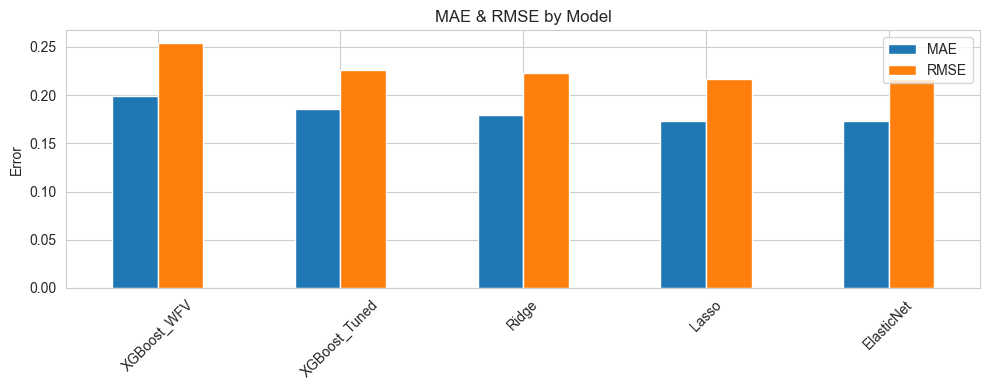

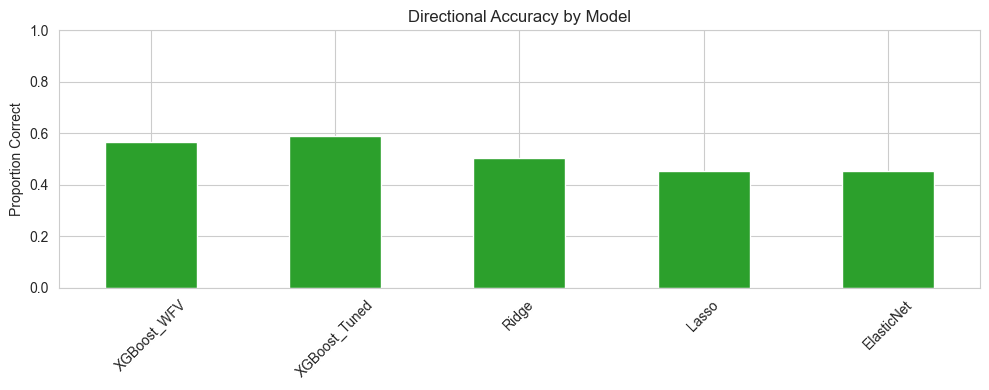

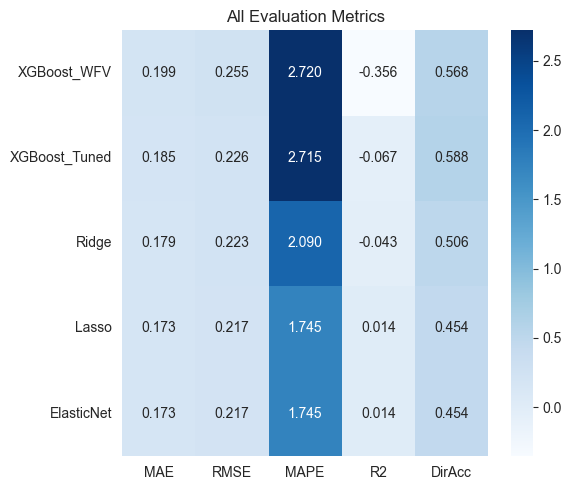

/tmp/ipykernel_98891/1601543648.py:32: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  plt.tight_layout()
/home/mh13/code/Tesla-S/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


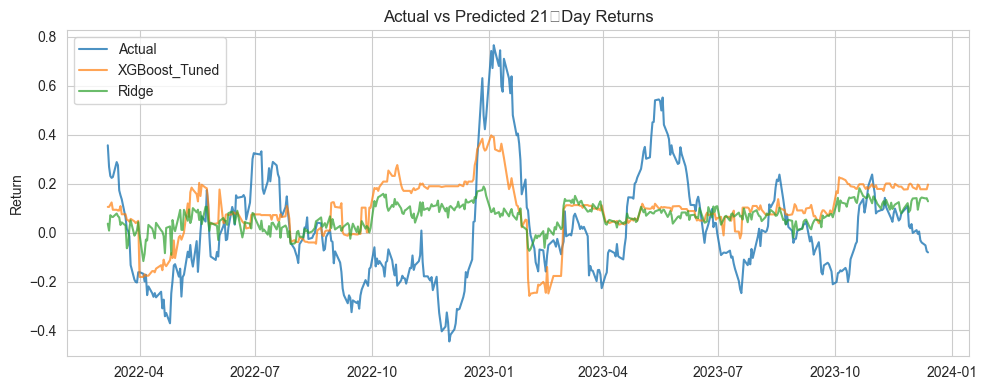

In [ ]:
# Bar charts for MAE & RMSE
metrics_df[['MAE','RMSE']].plot.bar()
plt.title('MAE & RMSE by Model')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar chart for Directional Accuracy
metrics_df['DirAcc'].plot.bar(color='C2')
plt.title('Directional Accuracy by Model')
plt.ylabel('Proportion Correct')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cell X+3: Heatmap of all metrics
plt.figure(figsize=(6,5))
sns.heatmap(metrics_df, annot=True, cmap='Blues', fmt='.3f')
plt.title('All Evaluation Metrics')
plt.tight_layout()
plt.show()

# Cell X+4: Actual vs Predicted for top-2 models
plt.plot(y_test.index, y_test, label='Actual', alpha=0.8)
plt.plot(y_test.index, y_pred_xgb, label='XGBoost_Tuned', alpha=0.7)
plt.plot(y_test.index, y_ridge,  label='Ridge', alpha=0.7)
plt.legend(loc='upper left')
plt.title('Actual vs Predicted 21-Day Returns')
plt.ylabel('Return')
plt.tight_layout()
plt.show()
